In [1]:
import numpy as np
import requests
import skimage
import sonnet as snt
import tensorflow as tf
import ipywidgets as widgets
import matplotlib.pyplot as plt

keras = tf.keras
K = keras.backend

from ipywidgets import interact, interactive, Layout, HBox
from skimage.transform import rescale, warp, ProjectiveTransform
from sklearn.preprocessing import OneHotEncoder

# extra code
import helpers

/home/euler/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Spatial Transformer Networks

[Spatial Transformer Networks, by Jaderberg, M. et. al](https://arxiv.org/pdf/1506.02025.pdf) explores a new convolutional neural network (CNN) module designed by the authors at Google Deepmind.
It allows a network to incorporate spatial transformations, typically on the input layer, which can have the effect of cropping, reorienting, or undistorting the layer in question.
The authors show how spatial transformations can take the place of attention networks, and additionally solve previous problems with translational invariance in CNNs.
It can be added seamlessly to any neural network. 
It is differentiable, and and therefore trained through simple backpropogation.

First, let's consider the motivations behind spatial transformer networks, starting with attention mechanisms in neural architecture.

### Attention

Attention mechanisms in neural networks give them the ability to focus on subsets of features.

![Image]()

Why is this so effective?  Here's the intuition I could come up with: Part of it is the problem space of most testing with CNNs: Single object classification or some single object-based task. Even extending this to several objects, there is often a large amount of irrelevant background information in the images. As such, this is an effective dimensionality reduction technique. 

To contrast, it may not be effective for segmentation of a large number of objects, or for semantic segmentation tasks, or for something like predicting if artwork will be popular.
In other words, tasks where you might expect important features to be comprehensively spread through the image.

In CNNs, we can consider attention in other image processing terms, taking the form of a binary or probability mask over an image (or layer), thereby focusing the effective activations within a small region.
This naive method of attention works, but with a heavy computational load. Kernels must still be computed over the whole image.

Another proposed option, is to crop the image.
However, this method also faces problems, as it so far has been non-differentiable, so some sort of stochastic or baked-in cropping method must be implemented.

As we'll see, image cropping can actually be modeled by a constrained linear transformation.


### Translational Invariance







Next, let's quickly go over basic spatial transforms.

The two important concepts involved here are:

### Spatial Transformations

For a much deeper look at these spatial transformations, [check out this resource](https://people.cs.clemson.edu/~dhouse/courses/401/notes/affines-matrices.pdf)

A "spatial transformation" is a transformation on the *coordinate system* of an image.

Let a pixel $P$ be defined at: $(x, y)$

then the transformation $T_\theta$ maps the pixel $P$ to a point $(x', y')$

The most basic forms of spatial transformations are linear or projective transformations, which can be represented with matrix multiplication.
Let's look at some examples of these matrices, to have a look at what the *parameters* of such transformations are.

##### linear

for a "rigid body" transformation, we have 3 parameters, $t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} \cos(\theta) & -\sin(\theta) & -t_x \\ \sin(\theta) & \cos(\theta) & -t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

a "similarity" transformation, with 4 parameters $s, t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} s \cos(\theta) &  -s \sin(\theta) & -t_x \\ s \sin(\theta) & s \cos(\theta) & -t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

for more general, "affine" transformations, 6 parameters $a, b, c, d, t_x, t_y, \theta$:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & t_x \\ c & d & t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

finally, "homographic" or "projective" transformations (our first nonlinear transform), with 8 parameters:

$$\begin{aligned}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & t_x \\ c & d & t_y \\ e & f & t_z \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{aligned}
$$

These parameters are also called the "degrees of freedom" of the transform, where the degrees of freedom are the minimum number of parameters required to fully specify that type of transformation.
In the projective transform, although the number of variables shown is 9, the last row has the constraint of always summing to 1, hence you can remove one parameter.

### sampling

the caveat with these transforms, is that $(x', y')$ are typically not integers, which conflicts with the *digital* representation of images.
To handle this, we'll need sampling theory.


**Interactive Notebook Kernel**: if this notebook is being run on a kernel, we can explore affine transforms and sampling with the interactive widget:


In [2]:
N = 128
square2 = np.zeros((N, N))
square2[60:100, 60:100] = 1
horse = rescale(skimage.data.horse(), .5, anti_aliasing=True, multichannel=False, mode='constant')
coffee = rescale(skimage.data.coffee(), 1.0, anti_aliasing=True, multichannel=True, mode='constant')
interp_dict = dict(
    [(y, x) for x, y in enumerate(['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'])]
)
def f(tx, ty, θ, s, kx, ky, interp=None, image='square'):
    fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
    interp = interp_dict[interp]  # skimage uses integer codes for interpolation.
    if interp == 2:
        print("ERROR: can't use thin plate spline interpolation due to a bug in scipy")
        interp = 1
    θ =  θ / 180 * np.pi
    mat = np.array([
        [s * np.cos(θ),  -s * (np.sin(θ) + kx), tx],
        [s * (np.sin(θ) + ky), s * np.cos(θ), ty],
        [0, 0, 1]
    ])
    if image == 'square':
        image = square2
        cmap = 'gray'
    elif image == 'horse':
        image = horse
        dims = image.shape
        cmap = 'gray'
    elif image == 'coffee':
        image = coffee
        cmap = 'RGB'
    xdim = image.shape[1]
    ydim = image.shape[0]
    shiftR = np.array([
            [1, 0, -xdim],
            [0, 1, -ydim],
            [0, 0, 1] # rigid body
        ])
    shiftL = np.array([
            [1, 0, xdim/2],
            [0, 1, ydim/2],
            [0, 0, 1] # rigid body
        ])
    mat = shiftL @ mat @ shiftR
    
    img = warp(image, mat, output_shape=([2*x for x in image.shape]), 
               order=interp, mode='constant')
    if cmap != 'RGB':
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.grid()

def reset_values(b):
    for child in plot2.children:
        if not hasattr(child, 'description'):
            continue
        elif child.description in ['tx', 'ty', 'θ', 'kx', 'ky']:
            child.value = 0
        elif child.description in ['s']:
            child.value = 1.0

reset_button = widgets.Button(description = "Reset")
reset_button.on_click(reset_values)

x2 = widgets.IntSlider(min=-200, max=200, step=9.8, orientation='vertical', description='$t_x$')
y2 = widgets.IntSlider(min=-200, max=200, step=9.8, orientation='vertical', description='$t_y$')
t2 = widgets.IntSlider(min=-180, max=180, step=18, orientation='vertical', description=r'$\theta$')
kx = widgets.FloatSlider(min=-2.0, max=2.0, value=0.0, orientation='vertical', description='$k_x$')
ky = widgets.FloatSlider(min=-2.0, max=2.0, value=0.0, orientation='vertical', description='$k_y$')
s = widgets.FloatSlider(min=0, max=2.0, value=1, orientation='vertical', description='$s$')
interpolation = widgets.RadioButtons(
    options=['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'][::-1], value='Linear', description='interpolation')
images = widgets.RadioButtons(options=['square', 'horse', 'coffee'])
plot2 = interactive(f, tx=x2, ty=y2, θ=t2, s=s, kx=kx, ky=ky,interp=interpolation, image=images)
layout = Layout(display='flex', flex_flow='row', justify_content='space-between')

In [3]:
plot2.update()
display(HBox([plot2.children[-1], images]))
display(HBox([*plot2.children[:-2], reset_button], layout=layout))

The widget above shows for a particular parameterization (defined on the sliders) of the affine transformation, what the end effect will be on the image.
You can choose between the square, an outline of a horse, and a photograph of a coffee cup.
I encourage you to test out both the available parameters.
You can also toggle different interpolation methods, to see how choice of sampling affects the output image (quadratic does not work due to a bug in the current version of scikit-image).

### The Spatial Transformer Module: 2 pieces

The Spatial Transformer consists of three pieces, a "localization network", a "grid generator", and a sampler\*.

![network configuration](img/STN_figure_2.png)

##### the localization network

The localization network is how the spatial transformation is decided for each input in the forward pass. 
It's simple in concept, it is a standard CNN, where the output units are the free parameters in the transformation model.
For example, if we wanted an affine transformation, the localization network should have 6 output units.  For a similarity transform, 4 output units, etc.
The rest is taken care of by backpropogation!
The weight initialization should be small, making the model very close to an identity transform at first.

##### the grid generator

The transformation T is generated from the above network's parameters. Then we need to compute *which* points on the image we are sampling from after the transformation is applied, then place them into an output layer. The output layer may need not strictly be the same size as the input. In fact, the size of the output layer can be freely chosen.

![grid generator](img/STN_figure_3.png)


In the image above we can see the identity transformation contrasted with an affine transformation. The sampling grid generates the points which must be sampled onto. This is illustrated in the example above, where we see the quadrilateral of points on $U$ going directly into the next layer $V$. However, just like in the initial discussion of transformations, the points on the quadrilateral will not, in general, correspond directly to pixel coordinates in $U$. This is why we will need to *resample* the points.

##### sampling

The remaining issue is to recompute the value of the points we sample from on the image.  Because they are in between pixel coordinates, they require sampling. *In this context, sampling has nothing to do with statistical sampling, it is interpolation.*


## By Example


In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train = onehot_encoder.fit_transform(y_train[..., np.newaxis])
y_test = onehot_encoder.fit_transform(y_test[..., np.newaxis])

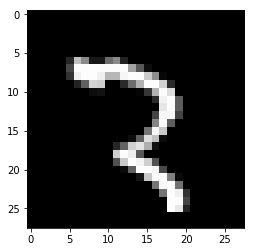

In [5]:
plt.imshow(X_train[500][:,:,0], cmap='gray')

### Defining the Model

We'll need to set up the pieces of the spatial transformer module, and then plug it into a standard CNN.

First, we'll define the localizer.
Remember that this is really the same as a small CNN.

I'll also define a standard cnn for classification.
This will help later for comparing STN results to regular networks.

In [6]:
def localizer(input_layer, constraints):
    if constraints is not None:
        num_params = constraints.num_free_params
    else:
        num_params = 6
    graph = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(input_layer)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(graph)
    graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(graph)
    graph = keras.layers.Flatten()(graph)

    theta = keras.layers.Dense(units=num_params, activation='sigmoid')(graph)

    return theta


def cnn_model_fn(input_layer, dense_units, num_classes):
    graph = input_layer
    for i in range(2):
        graph = keras.layers.Conv2D(filters=32 * 2**i, kernel_size=(3, 3), activation='relu')(graph)
        graph = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(graph)
    graph = keras.layers.Flatten()(graph)
    graph = keras.layers.Dense(
        units=dense_units, activation='sigmoid')(graph)
    dense = keras.layers.Dense(num_classes)(graph)
    logits = keras.layers.Activation('softmax', name='y')(dense)
    
    return logits

def standard_cnn(**pm):
    X = keras.layers.Input(
        shape=pm['input_shape'], name='X')
    output = cnn_model_fn(X, pm['dense_units'], pm['num_classes'])
    model = keras.Model(inputs=X, outputs=output)
    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model


Next, we'll define a special module, using Deepmind Sonnet's tensorflow package.
This module, which I'm calling the Spatial Transform Layer, is meant to take care of generating the grid points and the resampling.

I've defined it to accept a tuple of inputs: the input image, and the transform parameters (the output layer of the localization network). The tuple input works more seamlessly with keras.

In [7]:
class SpatialTransformLayer(snt.AbstractModule):
    """
    affine transform layer.
    Constructor requires output_shape, with optional
    constraints and boundary.
    """

    def __init__(self, output_shape,
                 constraints=None,
                 name='stn_layer'):
        """
        :param output_shape: shape of output layer (not including batch size)
        :param constraints: AffineWarpConstraints object from dm-sonnet package
        :param name: layer name
        """
        super().__init__(name=name)
        if constraints is None:
            # default is full affine transform
            constraints = snt.AffineWarpConstraints.no_constraints(num_dim=2)
        self._constraints = constraints
        self._output_shape = output_shape
        self.__name__ = name

    def _build(self, inputs):
        """
        Layer requires a tuple of arguments: an input layer
        and a set of transform parameters.
        """
        U, theta = inputs
        grid = snt.AffineGridWarper(
            source_shape=U.get_shape().as_list()[1:-1],
            output_shape=self._output_shape,
            constraints=self._constraints)(theta)
        V = tf.contrib.resampler.resampler(U, grid, name='resampler')

        return V


finally, we have the tools to finalize the model.
The format is basic, just to take inputs and transform them.

In [8]:
# define our keras model
def stn_model_fn(**pm):

    # input layer
    U = keras.layers.Input(
        shape=pm['input_shape'], name='X')

    # create localizationnetwork
    theta = localizer(U, pm['constraints'])

    grid_resampler = SpatialTransformLayer(output_shape=pm['output_shape'],
                                           constraints=pm['constraints'])

    # feed input U and parameters theta into the grid resampler
    V = keras.layers.Lambda(
        grid_resampler, output_shape=pm['output_shape'], name='V')([U, theta])

    # now input V to a standard cnn
    logits = cnn_model_fn(V, pm['dense_units'], pm['num_classes'])
    
    model = keras.Model(inputs=U, outputs=logits)
    opt = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model


# create some boundaries on the affine warp
constraints = snt.AffineWarpConstraints([[None, 0, None],
                                         [0, None, None]])

model_parameters = {
    'input_shape': (28, 28, 1),
    'batch_size': 32,
    'output_shape': (28, 28),
    'constraints': constraints,
    'dense_units': 128,
    'num_classes': 10
}


In [9]:
#normal_model = standard_cnn(**model_parameters)
#normal_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

In [10]:
model = stn_model_fn(**model_parameters)
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.5453 - acc: 0.8220 - val_loss: 0.2777 - val_acc: 0.8946
Epoch 2/10
60000/60000 [==============================] - 5s 92us/step - loss: 0.2791 - acc: 0.8954 - val_loss: 0.2499 - val_acc: 0.9031
Epoch 3/10
60000/60000 [==============================] - 5s 92us/step - loss: 0.2563 - acc: 0.9017 - val_loss: 0.2507 - val_acc: 0.9042
Epoch 4/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.2384 - acc: 0.9065 - val_loss: 0.2369 - val_acc: 0.9082
Epoch 5/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2315 - acc: 0.9100 - val_loss: 0.2375 - val_acc: 0.9096
Epoch 6/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.2327 - acc: 0.9103 - val_loss: 0.2368 - val_acc: 0.9074
Epoch 7/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2291 - acc: 0.9103 - val_loss: 0.2386 - val_ac